In [73]:
import os

import yfinance as yf
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import talib as ta


In [74]:
def get_time_stamp():
    return datetime.now().strftime('%Y%m%d%H%M%S')

In [75]:
directory = 'idx-' + get_time_stamp()
os.makedirs(directory, exist_ok=True)

In [76]:
def get_btc_idr(time_from, time_to) :
    pair = 'BTCIDR'
    time_frame = '1D'
    return requests.get('https://indodax.com/tradingview/history_v2?from=' + str(time_from) + '&symbol=' + pair +'&tf=' + time_frame + '&to=' + str(time_to)).json()

In [77]:
now = datetime.now()
past = now - timedelta(days=5*365)
time_from_s = int(time.mktime(past.timetuple()))
time_to_s = int(time.mktime(now.timetuple()))
time_from_date = past.strftime('%Y-%m-%d')
time_to_date = now.strftime('%Y-%m-%d')

In [78]:
def get_df_btc_idr(time_from, time_to) :
    btc_idr_daily = get_btc_idr(time_from, time_to)
    df_daily = pd.DataFrame(btc_idr_daily)
    if df_daily.empty :
        return df_daily
    df_daily['Date'] = pd.to_datetime(df_daily['Time'], unit='s')
    df_daily = df_daily.sort_values(by='Date')
    df_daily.set_index('Date', inplace=True)
    df_weekly = df_daily.resample('W-FRI').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    df_weekly.reset_index(inplace=True)
    return df_weekly

In [79]:
df_btc_idr = get_df_btc_idr(time_from_s, time_to_s)
# print(df_btc_idr)

In [80]:
stock_list_excel = pd.read_excel('Stock List.xlsx')
stock_list = stock_list_excel['Code']

In [81]:
def get_df_yf(ticker, time_from, time_to) :
    stock_daily = yf.download(ticker, start=time_from, end=time_to, interval='1d', multi_level_index=False)
    stock_weekly = stock_daily.resample('W-FRI').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    stock_weekly.dropna(inplace=True)
    stock_weekly.reset_index(inplace=True)
    return stock_weekly

In [82]:
def get_df_stock_idr(ticker, time_from, time_to) :
    return get_df_yf(ticker + '.JK', time_from, time_to)

In [83]:
def get_df_ihsg(time_from, time_to) :
    return get_df_yf('^JKSE', time_from, time_to)

In [84]:
def get_df_usd_idr(time_from, time_to) :
    return get_df_yf('IDR=X', time_from, time_to)

In [85]:
def get_df_xau_idr(time_from, time_to) :
    troy_ounce = 31.1035
    xau_usd_troy_ounce_df = get_df_yf('GC=F', time_from, time_to)
    usd_idr_df = get_df_usd_idr(time_from, time_to)

    df_merged = pd.merge(xau_usd_troy_ounce_df, usd_idr_df, on='Date', suffixes=('_main', '_base'))
    df_merged['Open_main_base'] = df_merged['Open_main'] * df_merged['Open_base'] / troy_ounce
    df_merged['High_main_base'] = df_merged['High_main'] * df_merged['High_base'] / troy_ounce
    df_merged['Low_main_base'] = df_merged['Low_main'] * df_merged['Low_base'] / troy_ounce
    df_merged['Close_main_base'] = df_merged['Close_main'] * df_merged['Close_base'] / troy_ounce
    df_merged['Volume_main_base'] = df_merged['Volume_main']

    df_final = df_merged[['Date', 'Open_main_base', 'High_main_base', 'Low_main_base', 'Close_main_base', 'Volume_main_base']].copy()
    df_final.rename(columns={
        'Open_main_base': 'Open',
        'High_main_base': 'High',
        'Low_main_base': 'Low',
        'Close_main_base': 'Close',
        'Volume_main_base': 'Volume'
    }, inplace=True)

    return df_final

In [86]:
df_xau_idr = get_df_xau_idr(time_from_date, time_to_date)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GC=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IDR=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [87]:
def calculate_change_price(df) :
    start = df['Close'].iloc[0]
    end = df['Close'].iloc[-1]
    percent = ((end-start)/start)*100
    return percent

In [88]:
def show_chart_change(df, chart_title) :
    width_ratio = 0.2
    width = width_ratio * len(df['Label'])
    plt.figure(figsize=(width, 6))
    plt.scatter(df['Label'], df['Data'], color='blue')
    plt.axhline(0, linestyle='--', alpha=0.5, color='red', label='Change = 0%')
    plt.title(chart_title)
    plt.xlabel('Ticker')
    plt.ylabel('Perubahan (%)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.text(0.5, 0.5, 'Generated by Yoga',
         transform=plt.gca().transAxes,
         fontsize=40, color='gray', alpha=0.3,
         ha='center', va='center', rotation=30)
    plt.text(0.99, 1.05, datetime.now().strftime('%d-%m-%Y %H:%M:%S'),
         transform=plt.gca().transAxes,
         fontsize=12, color='gray', alpha=0.7,
         ha='right', va='bottom')
    # plt.show()
    plt.savefig(os.path.join(directory, chart_title + '.png'), dpi=300, bbox_inches='tight')
    plt.close()

In [89]:
def get_indicator(df_final) :
    df_final['RSI_14'] = ta.RSI(df_final['Close'], timeperiod=14)

    df_final['OBV'] = ta.OBV(df_final['Close'], df_final['Volume'])

    slowk, slowd = ta.STOCH(df_final['High'], df_final['Low'], df_final['Close'],
                           fastk_period=5,
                           slowk_period=3,
                           slowd_period=3)
    df_final['Stoch_%K'] = slowk
    df_final['Stoch_%D'] = slowd
    return df_final

In [90]:
def get_history_btc_pair(stock_ticker, df_stock_idr_weekly, df_btc_idr_weekly) :
    ticker_name_low = stock_ticker.lower()
    df_merged = pd.merge(df_stock_idr_weekly, df_btc_idr_weekly, on='Date', suffixes=('_'+ticker_name_low, '_btc'))
    df_merged['Open_' + ticker_name_low +'_btc'] = df_merged['Open_' + ticker_name_low] / df_merged['Open_btc']
    df_merged['High_' + ticker_name_low +'_btc'] = df_merged['High_' + ticker_name_low] / df_merged['High_btc']
    df_merged['Low_' + ticker_name_low + '_btc'] = df_merged['Low_' + ticker_name_low] / df_merged['Low_btc']
    df_merged['Close_'+ ticker_name_low +'_btc'] = df_merged['Close_' + ticker_name_low] / df_merged['Close_btc']
    df_merged['Volume_'+ ticker_name_low +'_btc'] = df_merged['Volume_' + ticker_name_low]

    df_final = df_merged[['Date', 'Open_' + ticker_name_low +'_btc', 'High_' + ticker_name_low +'_btc', 'Low_' + ticker_name_low + '_btc', 'Close_' + ticker_name_low +'_btc', 'Volume_' + ticker_name_low +'_btc']].copy()
    df_final.rename(columns={
        'Open_' + ticker_name_low +'_btc': 'Open',
        'High_' + ticker_name_low +'_btc': 'High',
        'Low_' + ticker_name_low + '_btc': 'Low',
        'Close_' + ticker_name_low +'_btc': 'Close',
        'Volume_' + ticker_name_low +'_btc': 'Volume'
    }, inplace=True)

    mask = df_final['High'] < df_final['Low']
    df_final.loc[mask, ['High', 'Low']] = df_final.loc[mask, ['Low', 'High']].values
    df_final = get_indicator(df_final)
    return df_final

In [91]:
def resampling_monthly(df_weekly) :
    df_weekly.set_index('Date', inplace=True)
    df_monthly = df_weekly.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    df_monthly.reset_index(inplace=True)
    return df_monthly

In [92]:
def show_candlestick(ticker, ticker_base, df_stock_btc, timeframe_str):
    if timeframe_str == 'Monthly' :
        timeframe_id_str = 'Bulanan'
    else :
        timeframe_id_str = 'Mingguan'
    df_copy = df_stock_btc.copy()
    df_copy.set_index('Date', inplace=True)

    df_stock_btc.set_index('Date', inplace=True, drop=False)
    mpf.plot(df_copy,
             type='candle',
             style='binance',
             volume=True,
             title=f'Pergerakan Harga {timeframe_id_str} {ticker}/{ticker_base}',
             ylabel=f'Harga ({ticker_base})',
             savefig=dict(fname=os.path.join(directory, 'Candlestick-' + timeframe_str + '-' + ticker + '-' + ticker_base + '-' + get_time_stamp() + '.png'), dpi=300, bbox_inches='tight'))

In [93]:
def show_chart_rsi(df) :
    width = 0.2 * len(df['Label'])
    plt.figure(figsize=(width, 6))
    plt.scatter(df['Label'], df['RSI_14'], color='blue')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')
    plt.title('Nilai RSI Pair BTC')
    plt.xlabel('Ticker')
    plt.ylabel('RSI')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.text(0.5, 0.5, 'Generated by Yoga',
         transform=plt.gca().transAxes,
         fontsize=40, color='gray', alpha=0.3,
         ha='center', va='center', rotation=30)
    plt.text(0.99, 1.05, datetime.now().strftime('%d-%m-%Y %H:%M:%S'),
         transform=plt.gca().transAxes,
         fontsize=12, color='gray', alpha=0.7,
         ha='right', va='bottom')
    # plt.show()
    plt.savefig(os.path.join(directory, 'RSI-' + get_time_stamp() + '.png'), dpi=300, bbox_inches='tight')
    plt.close()

In [94]:
def show_chart(df, tickername, tickerbase, timeframe_str) :
    time_now = datetime.now().strftime('%d-%m-%Y %H:%M:%S')

    if timeframe_str == 'Monthly' :
        timeframe_id_str = 'Bulanan'
    else :
        timeframe_id_str = 'Mingguan'

    # Membuat figure dan dua subplot yang berbagi sumbu x
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

    # Pergerakan Harga
    ax1.plot(df['Date'], df['Close'], label=f'{tickername}/{tickerbase}', color='blue')
    # ax1.plot(df['Date'], df['EMA_13'], linewidth=0.5, label='EMA 13', color='yellow')
    # ax1.plot(df['Date'], df['EMA_21'], linewidth=0.5, label='EMA 21', color='orange')
    ax1.set_title(f'Pergerakan Harga {timeframe_id_str} {tickername} terhadap {tickerbase}')
    ax1.set_ylabel(f'Harga ({tickerbase})')
    ax1.legend()
    ax1.grid(True)
    ax1.text(0.99, 1.05, time_now,
         transform=ax1.transAxes,
         fontsize=12, color='gray', alpha=0.7,
         ha='right', va='bottom')
    ax1.text(0.5, 0.5, 'Generated by Yoga',
         transform=ax1.transAxes,
         fontsize=20, color='gray', alpha=0.3,
         ha='center', va='center', rotation=30)

    # RSI
    ax2.plot(df['Date'], df['RSI_14'], label=f'RSI {tickername} terhadap {tickerbase}', color='orange')
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')  # Garis overbought
    ax2.axhline(30, linestyle='--', alpha=0.5, color='green')  # Garis oversold
    ax2.set_title(f'Grafik RSI {tickername} terhadap {tickerbase}')
    ax2.set_xlabel('Tanggal')
    ax2.set_ylabel('RSI')
    ax2.legend()
    ax2.grid(True)
    ax2.text(0.99, 1.05, time_now,
         transform=ax2.transAxes,
         fontsize=12, color='gray', alpha=0.7,
         ha='right', va='bottom')
    ax2.text(0.5, 0.5, 'Generated by Yoga',
         transform=ax2.transAxes,
         fontsize=20, color='gray', alpha=0.3,
         ha='center', va='center', rotation=30)

    # Stochastic
    ax3.plot(df['Date'], df['Stoch_%K'], label='%K', color='blue')
    ax3.plot(df['Date'], df['Stoch_%D'], label='%D', color='orange')
    ax3.axhline(80, linestyle='--', alpha=0.5, color='red')  # Garis overbought
    ax3.axhline(20, linestyle='--', alpha=0.5, color='green')  # Garis oversold
    ax3.set_title(f'Grafik Stochastic {tickername} terhadap {tickerbase}')
    ax3.set_xlabel('Tanggal')
    ax3.set_ylabel('Nilai')
    ax3.legend()
    ax3.grid(True)
    ax3.text(0.99, 1.05, time_now,
         transform=ax3.transAxes,
         fontsize=12, color='gray', alpha=0.7,
         ha='right', va='bottom')
    ax3.text(0.5, 0.5, 'Generated by Yoga',
         transform=ax3.transAxes,
         fontsize=20, color='gray', alpha=0.3,
         ha='center', va='center', rotation=30)

    # OBV
    ax4.plot(df['Date'], df['OBV'], label='OBV', color='blue')
    ax4.set_title(f'Grafik OBV {tickername} terhadap {tickerbase}')
    ax4.set_xlabel('Tanggal')
    ax4.set_ylabel('Nilai')
    ax4.legend()
    ax4.grid(True)
    ax4.text(0.99, 1.05, time_now,
         transform=ax4.transAxes,
         fontsize=12, color='gray', alpha=0.7,
         ha='right', va='bottom')
    ax4.text(0.5, 0.5, 'Generated by Yoga',
         transform=ax4.transAxes,
         fontsize=20, color='gray', alpha=0.3,
         ha='center', va='center', rotation=30)

    # Menyesuaikan tata letak agar tidak saling tumpang tindih
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(directory, 'Chart-' + timeframe_str + '-' + tickername + '-' + tickerbase + '-' + get_time_stamp() + '.png'), dpi=300, bbox_inches='tight')
    plt.close()

In [95]:
def show_charts(tickers):
    change_3M_list = []
    change_6M_list = []
    change_1Y_list = []
    rsi_list = []

    for ticker in tickers:
        print('Processing ' + ticker + '...')
        df_stock_idr = get_df_stock_idr(ticker, time_from_date, time_to_date)
        df_stock_btc = get_history_btc_pair(ticker, df_stock_idr, df_btc_idr)
        df_stock_xau = get_history_btc_pair(ticker, df_stock_idr, df_xau_idr)

        show_candlestick(ticker, 'BTC', df_stock_btc, 'Weekly')
        show_chart(df_stock_btc, ticker, 'BTC', 'Weekly')

        show_candlestick(ticker, 'XAU', df_stock_xau, 'Weekly')
        show_chart(df_stock_xau, ticker, 'XAU', 'Weekly')

        three_months_ago = now - timedelta(days=90)
        six_months_ago = now - timedelta(days=180)
        years_ago = now - timedelta(days=365)

        df_three_months_ago = df_stock_btc[df_stock_btc['Date'] >= three_months_ago]
        df_six_months_ago = df_stock_btc[df_stock_btc['Date'] >= six_months_ago]
        df_years_ago = df_stock_btc[df_stock_btc['Date'] >= years_ago]

        latest_change_3M = calculate_change_price(df_three_months_ago)
        latest_change_6M = calculate_change_price(df_six_months_ago)
        latest_change_1Y = calculate_change_price(df_years_ago)

        change_3M_list.append({'Label': ticker, 'Data': latest_change_3M})
        change_6M_list.append({'Label': ticker, 'Data': latest_change_6M})
        change_1Y_list.append({'Label': ticker, 'Data': latest_change_1Y})

        latest_rsi = df_stock_btc['RSI_14'].iloc[-1]
        rsi_list.append({'Label': ticker, 'RSI_14': latest_rsi})

        if len(df_stock_btc['Close']) >= 100:
            df_stock_btc_monthly = resampling_monthly(df_stock_btc)
            df_stock_btc_monthly = get_indicator(df_stock_btc_monthly)
            show_candlestick(ticker, 'BTC', df_stock_btc_monthly, 'Monthly')
            show_chart(df_stock_btc_monthly, ticker, 'BTC', 'Monthly')

        if len(df_stock_xau['Close']) >= 100:
            df_stock_xau_monthly = resampling_monthly(df_stock_xau)
            df_stock_xau_monthly = get_indicator(df_stock_xau_monthly)
            show_candlestick(ticker, 'XAU', df_stock_xau_monthly, 'Monthly')
            show_chart(df_stock_xau_monthly, ticker, 'XAU', 'Monthly')

    change_3M_list = sorted(change_3M_list, key=lambda x: x['Data'])
    change_3M_list_df = pd.DataFrame(change_3M_list)
    change_6M_list = sorted(change_6M_list, key=lambda x: x['Data'])
    change_6M_list_df = pd.DataFrame(change_6M_list)
    change_1Y_list = sorted(change_1Y_list, key=lambda x: x['Data'])
    change_1Y_list_df = pd.DataFrame(change_1Y_list)

    show_chart_change(change_3M_list_df, 'Perubahan Harga 3 Bulan Terakhir Pair BTC')
    show_chart_change(change_6M_list_df, 'Perubahan Harga 6 Bulan Terakhir Pair BTC')
    show_chart_change(change_1Y_list_df, 'Perubahan Harga 1 Tahun Terakhir Pair BTC')

    rsi_list = sorted(rsi_list, key=lambda x: x['RSI_14'])
    rsi_df = pd.DataFrame(rsi_list)
    show_chart_rsi(rsi_df)

    excel_file = os.path.join(directory, 'price_idx-' + get_time_stamp() + '.xlsx')
    with pd.ExcelWriter(excel_file) as writer:
        change_3M_list_df.to_excel(writer, sheet_name='Change 3M', index=False)
        change_6M_list_df.to_excel(writer, sheet_name='Change 6M', index=False)
        change_1Y_list_df.to_excel(writer, sheet_name='Change 1Y', index=False)
        rsi_df.to_excel(writer, sheet_name='RSI', index=False)


Processing AALI...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AALI.JK']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


IndexError: index -1 is out of bounds for axis 0 with size 0

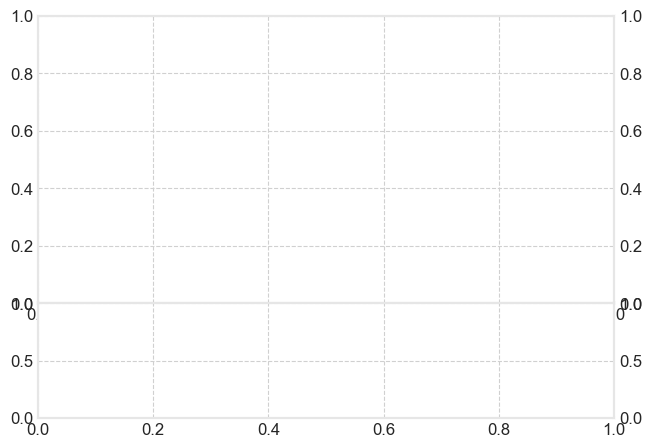

In [96]:
show_charts(stock_list)